In [83]:
import os, sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import math
import torch.nn.functional as F

from src.models.srcnn import SRCNN
from src.models.unet_sr import UNetSR
from src.data.dataset_pairs import UpscaleDataset
from skimage.metrics import structural_similarity as ssim


Found 492 image pairs.
Dataset size: 492
LR: torch.Size([3, 64, 64]) HR: torch.Size([3, 256, 256])


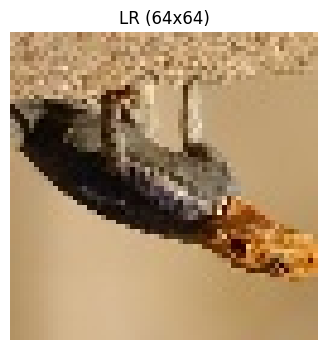

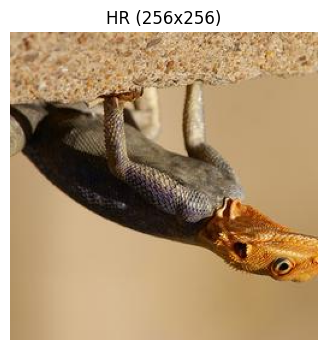

In [84]:
def find_project_root(start_path):
    cur = os.path.abspath(start_path)
    while True:
        if os.path.isdir(os.path.join(cur, "src")):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            break
        cur = parent
    raise RuntimeError("Project root not found.")

ROOT = find_project_root(os.getcwd())
sys.path.append(ROOT)
os.chdir(ROOT)

dataset = UpscaleDataset(
    lr_dir="./data/train_lr",
    hr_dir="./data/train_hr"
)

print("Dataset size:", len(dataset))

lr, hr = dataset[0]
print("LR:", lr.shape, "HR:", hr.shape)

def show_tensor(img_tensor, title=""):
    """
    img_tensor: torch.Tensor, (C,H,W), 值域 [0,1]
    """
    img = img_tensor.permute(1, 2, 0).cpu().numpy()   # CHW → HWC
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

show_tensor(lr, "LR (64x64)")
show_tensor(hr, "HR (256x256)")


In [85]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

srcnn = SRCNN().to(device)
unet = UNetSR().to(device)

srcnn_state = torch.load("models_ckpt/srcnn_final.pth", map_location=device)
srcnn.load_state_dict(srcnn_state)
srcnn.eval()

unet_state = torch.load("models_ckpt/unet_final.pth", map_location=device)
unet.load_state_dict(unet_state)
unet.eval()

print("Models loaded.")

Using device: cuda
Models loaded.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019664703..0.9371992].


SRCNN output shape: torch.Size([3, 256, 256])


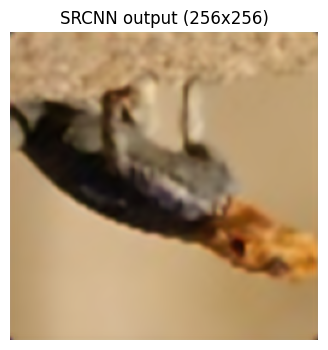

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009022772..0.88776845].


UNet output shape: torch.Size([3, 256, 256])


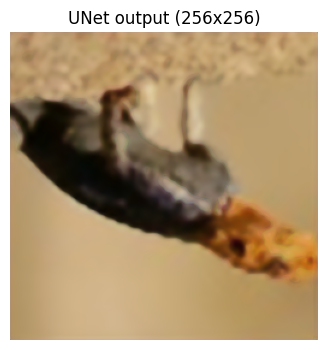

In [86]:
lr_input = lr.unsqueeze(0).to(device)   # (1,3,64,64)

with torch.no_grad():
    srcnn_out = srcnn(lr_input).squeeze(0).cpu()
    unet_out = unet(lr_input).squeeze(0).cpu()
    
print("SRCNN output shape:", srcnn_out.shape)
show_tensor(srcnn_out, "SRCNN output (256x256)")

print("UNet output shape:", unet_out.shape)
show_tensor(unet_out, "UNet output (256x256)")

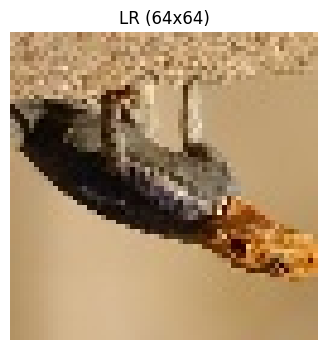

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11243127..1.0545385].


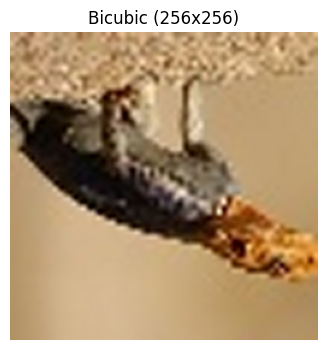

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019664703..0.9371992].


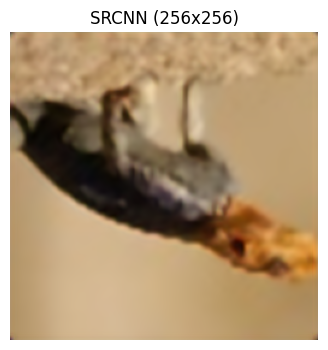

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009022772..0.88776845].


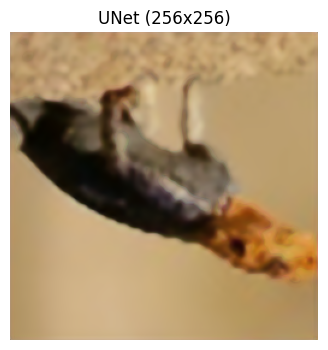

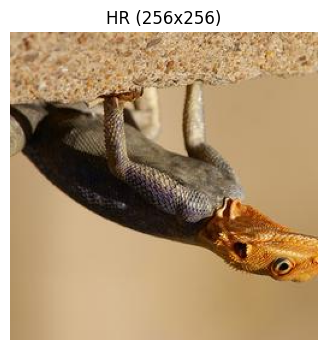

In [87]:
def upscale_bicubic(lr_tensor, scale_factor=4):
    x = lr_tensor.unsqueeze(0)  # (1,3,H,W)
    x_up = F.interpolate(x, scale_factor=scale_factor, mode="bicubic", align_corners=False)
    return x_up.squeeze(0)

bicubic = upscale_bicubic(lr)

show_tensor(lr,      "LR (64x64)")
show_tensor(bicubic, "Bicubic (256x256)")
show_tensor(srcnn_out,     "SRCNN (256x256)")
show_tensor(unet_out,      "UNet (256x256)")
show_tensor(hr,      "HR (256x256)")

In [88]:
def psnr(img1, img2):
    """
    img1, img2: torch.Tensor, shape (3,H,W), in [0,1]
    """
    mse = torch.mean((img1 - img2) ** 2).item()
    if mse == 0:
        return float("inf")
    return 10 * math.log10(1.0 / mse)

In [89]:
def ssim_torch(img1, img2):
    """
    img1, img2: torch.Tensor, shape (3,H,W), in [0,1]
    回傳單一 SSIM 值（float）
    """
    x1 = img1.permute(1, 2, 0).cpu().numpy()  # (H,W,3)
    x2 = img2.permute(1, 2, 0).cpu().numpy()
    
    # skimage >= 0.19 用 channel_axis
    return ssim(x1, x2, data_range=1.0, channel_axis=2)

In [90]:
bicubic_psnr = psnr(bicubic, hr)
srcnn_psnr   = psnr(srcnn_out, hr)
unet_psnr   = psnr(unet_out, hr)

bicubic_ssim = ssim_torch(bicubic, hr)
srcnn_ssim   = ssim_torch(srcnn_out, hr)
unet_ssim   = ssim_torch(unet_out, hr)

print(f"PSNR (Bicubic vs HR): {bicubic_psnr:.2f} dB")
print(f"PSNR (SRCNN vs HR):   {srcnn_psnr:.2f} dB")
print(f"PSNR (UNet vs HR):    {unet_psnr:.2f} dB")

print(f"SSIM (Bicubic vs HR): {bicubic_ssim:.4f}")
print(f"SSIM (SRCNN vs HR):   {srcnn_ssim:.4f}")
print(f"SSIM (UNet vs HR):    {unet_ssim:.4f}")

PSNR (Bicubic vs HR): 21.76 dB
PSNR (SRCNN vs HR):   22.58 dB
PSNR (UNet vs HR):    22.39 dB
SSIM (Bicubic vs HR): 0.6708
SSIM (SRCNN vs HR):   0.6692
SSIM (UNet vs HR):    0.6601


In [91]:
N = min(20, len(dataset))

bicubic_psnrs = []
srcnn_psnrs   = []
unet_psnrs   = []

bicubic_ssims = []
srcnn_ssims   = []
unet_ssims   = []

    
for i in range(N):
    lr_i, hr_i = dataset[i]
    
    # Bicubic
    bicubic_i = upscale_bicubic(lr_i)
    
    # SRCNN
    with torch.no_grad():
        lr_in = lr_i.unsqueeze(0).to(device)
        srcnn_i = srcnn(lr_in).squeeze(0).cpu()
        unet_i = unet(lr_in).squeeze(0).cpu()
    
    # PSNR
    bicubic_psnrs.append(psnr(bicubic_i, hr_i))
    srcnn_psnrs.append(psnr(srcnn_i, hr_i))
    unet_psnrs.append(psnr(unet_i, hr_i))
    
    # SSIM
    bicubic_ssims.append(ssim_torch(bicubic_i, hr_i))
    srcnn_ssims.append(ssim_torch(srcnn_i, hr_i))
    unet_ssims.append(ssim_torch(unet_i, hr_i))
    
import numpy as np

print(f"[PSNR over {N} images]")
print(f"  Bicubic: {np.mean(bicubic_psnrs):.2f} dB")
print(f"  SRCNN:   {np.mean(srcnn_psnrs):.2f} dB")
print(f"  UNet:    {np.mean(unet_psnrs):.2f} dB")
print(f"[SSIM over {N} images]")
print(f"  Bicubic: {np.mean(bicubic_ssims):.4f}")
print(f"  SRCNN:   {np.mean(srcnn_ssims):.4f}")
print(f"  UNet:    {np.mean(unet_ssims):.4f}")


[PSNR over 20 images]
  Bicubic: 18.60 dB
  SRCNN:   19.67 dB
  UNet:    19.45 dB
[SSIM over 20 images]
  Bicubic: 0.4253
  SRCNN:   0.4126
  UNet:    0.4044
